# Домашняя работа

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
3. Построить случайный лес, вывести важность признаков
4. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
5. Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
6. Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
7. В качестве решения:
    Jupyter notebook с кодом, комментариями и графиками

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas_profiling
import numpy as np
from jupyterthemes import jtplot
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
%matplotlib inline
jtplot.style()

In [2]:
# загружаем датасет
data = pd.read_csv('train.csv')

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# проверяем датасет на полноту данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Уберем из датасета колонку id, так как она не несет никакой полезной информации кроме номера дома. Также уберем колонки Alley, FireplaceQu, PoolQC, Fence и MiscFeature - из-за большого количества Null значений.

In [5]:
data_clear = data.drop(['Id', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)

Также уберем все признаки в которых есть string значения, иначе RFC не будет работать. Разумеется, это некорректный подход, так как среди этих признаков могут оказаться полезные и их нужно искать и использовать на них OneHotEncoder, но прихнаков 80 штук, а времени у меня ограниценное количество.

In [6]:
for col in data_clear.columns:
    if data_clear[col].dtypes == 'object':
        data_clear.drop(col, axis=1, inplace=True)

In [7]:
# заполняем NaN значения медианами
data_clear.fillna(data_clear.median(), inplace=True)

In [8]:
from sklearn.model_selection import train_test_split

# разделяем датасет на значения для обучения и таргет значения
X = data_clear.drop('SalePrice', axis=1)
y = data_clear.SalePrice

# разбиваем на train/test выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [9]:
# строим случайный лес
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [10]:
# проверяем, с помощью кросс валидации, как обучилась модель
print(cross_val_score(clf_rf, X_train, y_train, cv=10))

C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[0.00747664 0.01058201 0.02752294 0.         0.15217391 0.03571429
 0.         0.         0.11111111 0.        ]


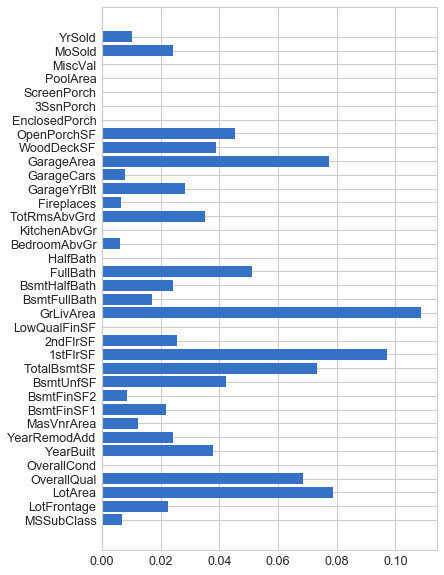

In [11]:
# выводим выжность признаков
plt.figure(figsize=(6,10))
plt.barh(np.arange(len(clf_rf.feature_importances_)), clf_rf.feature_importances_)
plt.yticks(np.arange(len(X_train.columns)),X_train.columns)
plt.show()

In [12]:
# обучаем логистическую регрессию
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
scaler.fit(X_train)
X_train_val = scaler.transform(X_train.values)
X_test_val = scaler.transform(X_test.values)

X_train_scl = pd.DataFrame(X_train_val, index=X_train.index, columns=X_train.columns)
X_test_scl = pd.DataFrame(X_test_val, index=X_test.index, columns=X_test.columns)

clf_lr = LogisticRegression(penalty='l1', C=0.1)
clf_lr.fit(X_train_scl, y_train)

C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
# обучаем линейную регрессию
from sklearn.linear_model import LinearRegression

clf_lin = LogisticRegression()
clf_lin.fit(X_train_scl, y_train)

C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
# реализцем стекинг, как в лекции
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict_proba(X_train.iloc[test_ind])[:, 1]
        meta_test += clf.predict_proba(X_test)[:, 1]
    
    return meta_train, meta_test / stack_cv.n_splits

In [15]:
from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=10, random_state=555)

meta_train = []
meta_test = []
col_names = []

print('LR features...')
meta_tr, meta_te = get_meta_features(clf_lr, X_train_scl, y_train, X_test_scl, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')

print('RF features...')
meta_tr, meta_te = get_meta_features(clf_rf, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

print('LinR features...')
meta_tr, meta_te = get_meta_features(clf_lin, X_train_scl, y_train, X_test_scl, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lin_pred')

LR features...


C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


RF features...


C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


LinR features...


C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [16]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

In [17]:
from sklearn.metrics import r2_score

In [18]:
# используем регуляризованную лог регрессию в качестве алгоритма второго уровня
clf_lr_meta = LogisticRegression(penalty='l2', C=1)
clf_lr_meta.fit(X_meta_train, y_train)

# для сравнения используем ту же лог регрессию но на обцчающей выборке
clf_lr_check = LogisticRegression(penalty='l2', C=1)
clf_lr_check.fit(X_train, y_train)

C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ivan\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Ivan\AppData\Roaming\Python\P

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
y_pred_meta_test = clf_lr_meta.predict_proba(X_meta_test)[:, 1]
y_pred_check_test = clf_lr_check.predict_proba(X_test)[:, 1]

print('Второй уровень:', r2_score(y_test, y_pred_meta_test))

print('Первый уровень:', r2_score(y_test, y_pred_check_test))

Второй уровень: -4.854070498966364
Первый уровень: -4.854070587606075
